In [1]:
from ast import literal_eval
from const_definitions import SolverEvents
from matplotlib import pyplot as plot
import numpy as np
import pandas as pd

In [2]:
def parse_numpy_data(item):
    item_eval = literal_eval(item)
    if item_eval is None:
        return np.array([])
    return np.array(item_eval)


column_parse_dict = {col: parse_numpy_data for col in ["Y", "DYDT_EST"]}

# Local Optima Tracking: Simple Example

We're interested in the DAEO
$$
\begin{aligned}
    x(0) &= 1 \\
    x\prime(t) &= -(2+y(t))\cdot x(t)\\
    \left\{y(t)\right\} &= \argmin_y h(x,y)
\end{aligned}
$$
with
$$
h(x,y) = \left(1-y^2\right)^2-\left(x-\frac{1}{2}\right)\sin\frac{\pi}{2}y
$$

which has the analytical solution
$$
x(t) = \begin{cases} \exp -3t & t\in\left[0,-\frac{1}{3}\ln\frac{1}{2}\right]\\
    \exp \left(-t+\frac{2}{3}\ln\frac{1}{2}\right) & t\in\left[-\frac{1}{3}\ln\frac{1}{2},1\right]
    \end{cases}
$$


In [3]:
def x_exact(t):
    t_e = -np.log(0.5)/3
    A = -2 * t_e
    return np.where(t<t_e, np.exp(-3*t), np.exp(-t + A))

In [4]:
def solution_indices(df: pd.DataFrame):
    indices = ((df["EVENTID"] == SolverEvents.TIME_STEP_NO_EVENT) |
               (df["EVENTID"] == SolverEvents.TIME_STEP_EVENT_CORRECTED) | 
               (df["EVENTID"] == SolverEvents.SOLVER_BEGIN))
               # (df["EVENTID"] == SolverEvents.SOLVER_COMPLETE))
    return indices

def error_series(solution_log: pd.DataFrame):
    err = solution_log["X"] - x_exact(solution_log["T"])
    return err

In [5]:
def convergence_data(h_min_pow: int):
    te_exact = -1 / 3 * np.log(0.5)
    dt = np.zeros(h_min_pow)
    l2_error_norm = np.zeros(h_min_pow)
    t_e_error = np.zeros(h_min_pow)
    for i in range(h_min_pow):
        solver_log = pd.read_csv(
            f"../data/out/simple_example_10_minus_{i:d}_solver_log.tsv",
            sep="\t",
            header=0,
            converters=column_parse_dict)
        solution_log = solver_log[solution_indices]
        dt[i] = np.power(10.0, -i)
        error = solution_log["X"] - x_exact(solution_log["T"])
        # l2 via right-riemann
        l2_error_norm[i] = np.sqrt(np.dot(error**2, solution_log["DT"]))
        event_correction = solution_log[solution_log.EVENTID ==
                                        SolverEvents.TIME_STEP_EVENT_CORRECTED]
        te_est = event_correction["T"].iloc[0]
        t_e_error[i] = np.abs(te_est - te_exact)
    return dt, l2_error_norm, t_e_error

In [15]:
soln = pd.read_csv(
    "../data/out/simple_example_10_minus_4_solver_log.tsv",
    sep="\t",
    header=0,
    converters=column_parse_dict)[solution_indices]


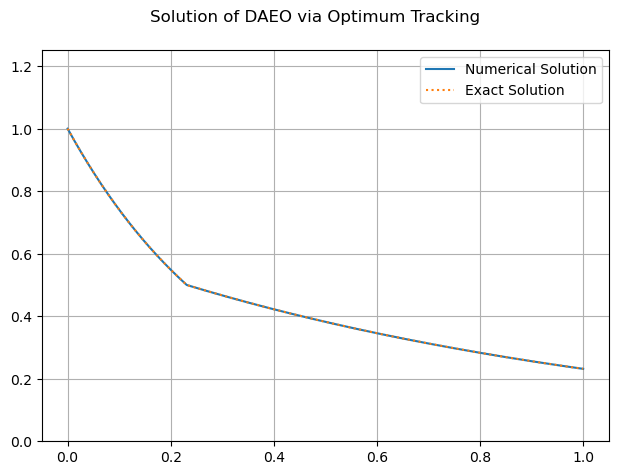

In [16]:
fig, ax = plot.subplots()
fig.suptitle("Solution of DAEO via Optimum Tracking")
fig.tight_layout()
ax.plot(soln["T"], soln["X"], label="Numerical Solution")
ax.plot(soln["T"], x_exact(soln["T"]), label="Exact Solution", ls=":")
ax.legend()
ax.set_ylim((0,1.25))
ax.grid(True)

In [9]:
dt, l2_err, evt_err = convergence_data(7)

In [10]:
evt_err

array([8.82685319e-03, 1.53988419e-03, 1.72541866e-05, 1.73186648e-07,
       2.18664842e-09, 1.86648419e-10, 1.86648419e-10])

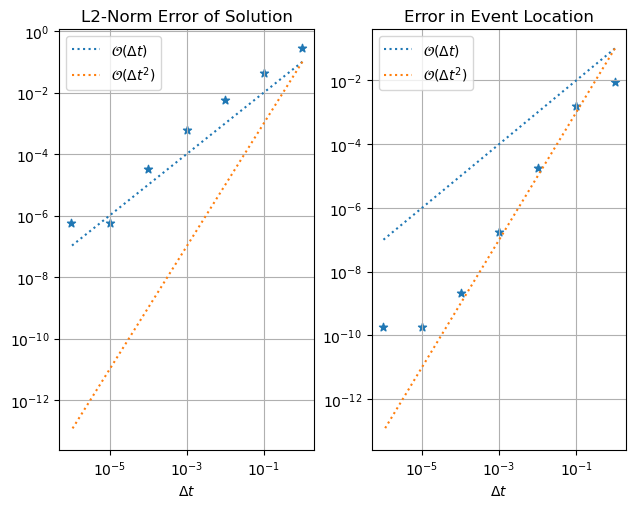

In [11]:
fig, ax = plot.subplots(1, 2)
fig.tight_layout()
for axis in ax:
    axis.set_yscale("log")
    axis.set_xscale("log")
    axis.grid(True)
    axis.set_xlabel("$\Delta t$")
    axis.plot(dt, 0.1*dt, label="$\mathcal{O}(\Delta t)$", ls=":")
    axis.plot(dt, 0.1*dt**2, label="$\mathcal{O}(\Delta t^2)$", ls=":")
    axis.legend()
ax[0].scatter(dt, l2_err, marker="*")
ax[0].set_title("L2-Norm Error of Solution")
ax[1].scatter(dt, evt_err, marker="*")
ax[1].set_title("Error in Event Location")
fig.savefig("../gfx/convergence_plot.png")
plot.show()